# Analyze Results from Classification models

<h2>Background</h2>

I found that running different models through Jupyter notebook just wasn't stable enough. The process would either crash or hang and found the speed much slower than if I ran them as a standalone programs. I also found that if I broke the steps down into different programs, it would run faster and was more reliable for me to check on results.

Here is a list of programs that I used to generate various feature files and results:

| File Name | Description | Helper Classes | Sample Config File |
|-----------|-------------|----------------|--------------------|
| [tsv_to_csv.py](tsv_to_csv.py) | I found that pandas did not handle reading in raw amazong review files (tsv) correctly. There were line breaks in the data file that caused pandas to be confused and would merge in multiple lines into one column cell which would sku the data. Needed to write this to convert the tsv to csv so pandas can read the data properly | N/A | N/A |
| [amazon_review_preprocessor.py](amazon_review_preprocessor.py) | Takes in converted amazon review csv file does pre-processing/cleaning of the data | [util.TextProcessor.py](util/TextProcessor.py) | N/A |
| [amazon_review_feature_file_generator.py](amazon_review_feature_file_generator.py) | Takes in preprocessed file generated from [amazon_review_preprocessor.py](amazon_review_preprocessor.py) and generate BoW or TFIDF feature files with different parameters. Parameters supported: various max_df, min_df, ngrams | [nlp.feature_util.py](nlp/feature_util.py) | [2019-05-21-amazon_review_feature_generation_config-bow.py](config/2019-05-21-amazon_review_feature_generation_config-bow.csv) |
| [generate_lda_features.py](generate_lda_features.py) | After processing data through [amazon_review_feature_file_generator.py](amazon_review_feature_file_generator.py), I used this program to do Topic Modeling using LDA with this program. Current setting picks 20 topics and generate resulting data files | N/A | [2019-05-21-amazon_review_generate_lda_feature_config-tfidf.cvs](config/2019-05-21-amazon_review_generate_lda_feature_config-tfidf.csv) |
| [run_classifiers.py](run_classifiers.py) | This was originally a python notebook that would take hours and hours to run. But the original notebook also combined the function of generating BoW and TF-IDF with various parameters encoding as well as running KNN and LogisticRegression with various parameters. This also generates reports using sklearn's classification_report for different models which we will interpret here. | [models/ClassifierRunner.py](models.ClassifierRunner.py) | [2019-05-23-run_classifiers-config.csv](config/template-run_classifiers.csv) |


<h2>Data and Models</h2>

Some issues that I ran into when trying to run various datasets against different models:

    * Radius Neighbor - as per previous notebook, radius was hard to set and would not be able to find neighbors depending on data set, plus this was the slowest out of all models so far. I decided to skip this even though sklearn recommends using this for imbalanced datasets.
    * Logistic Regression parameters - I tried using default settings for this which is 100. However, I found that it would not converge on most datasets that I used. Tried 200 then 300. 300 seems to at least come back with results so I stuck with this to start with
    * Time - had issues with this on multiple fronts
        * I found that without limiting features from feature files, there were 2 problems: (1) it would take arount 2.5 hours just to lead the data file (2) the models would take days to run which I never let complete. Finally I decided on using max_features in CountVectorizer and TFIDFVectorizers to limit the features to 10k features. This would take about 20 minutes to load each data file which was pretty reasonable compared to training time (see graphs below)
    * Storage - generating various feature file without using BoW and TF-IDF was taking up a lot of space on my laptop. I found that once I converted them into BoW or TF-IDF representation, the files would get much smaller. I did run out of storage on my machine multiple times and my program would stop working because of this.
    

<h3>ngram</h3>

I did try to generate features using ngram. However, I did find that this dramatically increased the feature matrix size. For a file that has ~100k entries. 47k unique features (unique word) would generated by BoW or TF-IDF. For the most part I did not use ngram without using min_df and max_df because I had issues with time needed to create feature files, storage, as well as issues with being able to complete the models when I used ngram alone. I ended up using max_features along with this to limit the size of my feature files.

| Sample Size | Features no ngram | ngram (1,2) | ngram (1,3) |
|------|------|------|---|
| 999 | 3323 | 17k | 32k |

<h3>min_df and max_df</h3>

I found that using these parameters with setting of min_df=0.005 and max_df=0.995 dramatically cut down the feature set size. Unfortunately, when I used this setting for 110k training examples, this cut down the number of features to around 4500 only. For this set of data, I did not use any min/max_df settings

<h3>LDA</h3>

Used LDA for topic modeling. Wasn't sure how many topics would be reasonable here. So for now I picked 20 topics. May play around with this more laterl Models with LDA, the 20 topics were appended to the dataframe as extra features.



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np


%matplotlib inline
sns.set()

In [2]:
DATA_FILE="reports/2019-05-31-run_classifiers-report.csv"

report = pd.read_csv(DATA_FILE)
report["total_size"] = report["train_examples"] + report["test_examples"]
report.head()

,1_f1-score,1_precision,1_recall,1_support,2_f1-score,2_precision,2_recall,2_support,3_f1-score,3_precision,...,test_features,total_time_min,train_examples,train_features,train_time_min,weighted avg_f1-score,weighted avg_precision,weighted avg_recall,weighted avg_support,total_size
0,0.617663,0.568708,0.675841,1635,0.110442,0.216535,0.074124,742,0.148952,0.281421,...,10020,2.67,48863,10020,0.25,0.584592,0.566651,0.64312,12500,61363
1,0.672576,0.614684,0.742508,1635,0.145530,0.318182,0.094340,742,0.204360,0.332594,...,10020,3.91,48863,10020,1.39,0.630786,0.623582,0.68216,12500,61363
2,0.658699,0.582160,0.758410,1635,0.063107,0.317073,0.035040,742,0.183150,0.359195,...,10020,56.36,48863,10020,53.70,0.614210,0.616178,0.67768,12500,61363
3,0.640244,0.638298,0.642202,1635,0.204733,0.173023,0.250674,742,0.292747,0.264706,...,10020,13.75,48863,10020,11.35,0.619382,0.651112,0.59760,12500,61363
4,0.611237,0.570143,0.658716,1635,0.091270,0.172932,0.061995,742,0.156293,0.263403,...,10020,3.24,48863,10020,0.27,0.581603,0.560676,0.63984,12500,61363


In [3]:
# Set up variables for the rest of this notebook
MODELS = sorted(report["model_name"].unique().tolist())
MODELS

['CB', 'LRB100', 'RF', 'lGBM']

## Description of which models we ran

Description Uses the following format

(classification model)-(column)-(feature extraction method)-(max/min df setting)-(ngram setting)-(sample size)[-(lda)]

    classification model
        which model we used to train and predict
    column
        which column in Amazon Reviews data set we used to create the feature set
    feature extraction method
        bow = Bag of Words
        tfidf = TF-IDF
    max/min df setting
        df_default = default settings for min_df and max_df
        df90 = min_df of 0.05 and max_df of 0.95
        df80 = min_df of 0.10 and max_def of 0.9
    ngram setting
        ngram11 = (1,1)
        ngram12 = (1,2)
        ngram13 = (1,3)
    lda
        Indicates whether LDA was used on top of feature extraction method. Currently using 20 topics
        
        
<b>Classification Models</b>

All models were executed with default settings

| model_name | Description |
|------------|-------------|
| KNN | KNearestNeighbors |
| LR | LogisticRegressionClassifier |
| LRB | Logistic Regression Classifier with class_weight="balanced" |
| RF | Random Forest Classifier |
| GB | Gradient Boost Classifier |
| lGBM | lightGBM Classifier |
| XGB | XGB Classifier |
| CB | CatBoost Classifier |


In [4]:
def split_desc(x):
    desc = x["description"]
    s_desc = desc.split("-")
    if len(s_desc) == 6:
        s_desc.append("n/a")
#     print(f'desc: {desc} len: {len(s_desc)}')
    return pd.Series(s_desc)
    

s = report[["description","status", "model_name"]].copy()
new_df = s.apply(split_desc, axis=1)
# get a list of unique models - we will use this later
s.join(new_df)

,description,status,model_name,0,1,2,3,4,5,6,7
0,review_body-bow-df_default-ngram12-50000-10020...,success,RF,review_body,bow,df_default,ngram12,50000,10020,lda20,smote
1,review_body-bow-df_default-ngram12-50000-10020...,success,lGBM,review_body,bow,df_default,ngram12,50000,10020,lda20,smote
2,review_body-bow-df_default-ngram12-50000-10020...,success,CB,review_body,bow,df_default,ngram12,50000,10020,lda20,smote
3,review_body-bow-df_default-ngram12-50000-10020...,success,LRB100,review_body,bow,df_default,ngram12,50000,10020,lda20,smote
4,review_body-tfidf-df_default-ngram12-50000-100...,success,RF,review_body,tfidf,df_default,ngram12,50000,10020,lda20,smote
5,review_body-tfidf-df_default-ngram12-50000-100...,success,lGBM,review_body,tfidf,df_default,ngram12,50000,10020,lda20,smote
6,review_body-tfidf-df_default-ngram12-50000-100...,success,CB,review_body,tfidf,df_default,ngram12,50000,10020,lda20,smote
7,review_body-tfidf-df_default-ngram12-50000-100...,success,LRB100,review_body,tfidf,df_default,ngram12,50000,10020,lda20,smote
8,review_body-bow-df_default-ngram12-111909-1002...,success,RF,review_body,bow,df_default,ngram12,111909,10020,lda20,smote
9,review_body-bow-df_default-ngram12-111909-1002...,success,lGBM,review_body,bow,df_default,ngram12,111909,10020,lda20,smote


In [5]:
report["label"] = report.apply(lambda x: f'{x["model_name"]}-{x["description"]}', axis=1)
# report = report.drop(labels=["model_name", "description"], axis=1).sort_values(["label"])
report = report.sort_values(["model_name", "train_features", "label"])
report.head(2)

,1_f1-score,1_precision,1_recall,1_support,2_f1-score,2_precision,2_recall,2_support,3_f1-score,3_precision,...,total_time_min,train_examples,train_features,train_time_min,weighted avg_f1-score,weighted avg_precision,weighted avg_recall,weighted avg_support,total_size,label
10,0.662589,0.590432,0.754839,3875,0.082752,0.337121,0.047165,1887,0.216524,0.400000,...,27.01,112031,10020,20.96,0.598292,0.596064,0.655015,27978,140009,CB-review_body-bow-df_default-ngram12-111909-1...
2,0.658699,0.582160,0.758410,1635,0.063107,0.317073,0.035040,742,0.183150,0.359195,...,56.36,48863,10020,53.70,0.614210,0.616178,0.677680,12500,61363,CB-review_body-bow-df_default-ngram12-50000-10...


# Failures

Let's look to see if any of our models failed and why

In [6]:
if "message" not in report.columns:
    print("No failures reported")
else:
    failures = report[report["status"] == "failed"][["label", "message"]]
    pd.set_option("display.max_colwidth", 200)
    failures.head()

No failures reported


# Star Ratings and SMOTE


SMOTE data is generated by increasing under-represented star ratings (1, 2, 3, 4) by 66%. Meaning that I pass in dictionary to sampling_strategy where class 0 = current count * 1.66, class 1 = current count * 1.66, etc

<b>NOTE:</b> date was generated from [get_distribution_df.py](get_distribution_df.py) a separate program so we don't have take 20 minutes to load the data files
    * Also, I have not executed any models with data with MOTE yet


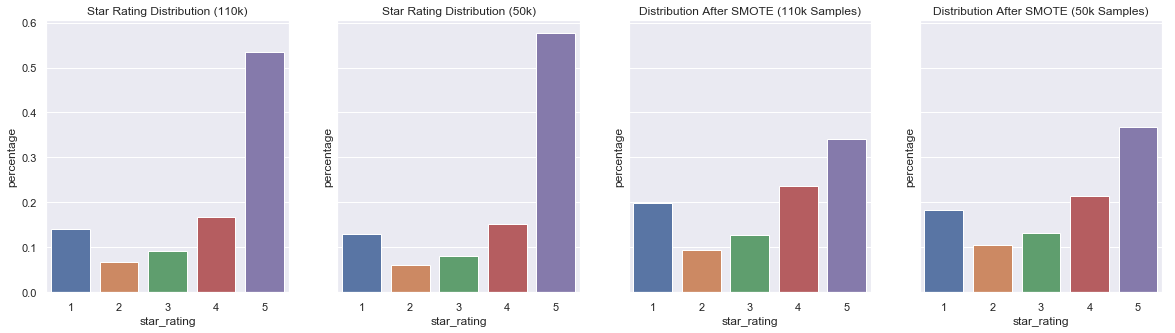

In [7]:

f, a = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(20, 5))
star_pd = pd.read_csv("dataset/feature_files/111909-hist.csv")
star_pd["percentage"] = star_pd["count"].apply(lambda x: x / pd.Series.sum(star_pd["count"]))
smote_pd = pd.read_csv("dataset/feature_files/111909smote-hist.csv")
smote_pd["percentage"] = smote_pd["count"].apply(lambda x: x / pd.Series.sum(smote_pd["count"]))
star50k_pd = pd.read_csv("dataset/feature_files/50000-hist.csv")
star50k_pd["percentage"] = star50k_pd["count"].apply(lambda x: x / pd.Series.sum(star50k_pd["count"]))
smote50k_pd = pd.read_csv("dataset/feature_files/50000smote-hist.csv")
smote50k_pd["percentage"] = smote50k_pd["count"].apply(lambda x: x / pd.Series.sum(smote50k_pd["count"]))

sns.barplot(data=star_pd, x="star_rating", y="percentage", ax=a[0])
a[0].set_title("Star Rating Distribution (110k)")
sns.barplot(data=star50k_pd, x="star_rating", y="percentage", ax=a[1])
_ = a[1].set_title("Star Rating Distribution (50k)")

sns.barplot(data=smote_pd, x="star_rating", y="percentage", ax=a[2])
_ = a[2].set_title("Distribution After SMOTE (110k Samples)")
sns.barplot(data=smote50k_pd, x="star_rating", y="percentage", ax=a[3])
_ = a[3].set_title("Distribution After SMOTE (50k Samples)")


# Feature Distribution Between ngram (1, 2) and (1, 3)

Features were also generated using the max_features=10k parameters in CountVectorizor and TFIDFVectorizer

max_features chooses features based on occurance in the corpus. Even with ngram(1,3) - most of the features are in the 1-word to 2-word ranges. This tells me that tri-grams that reoccur the the corpus is rare and may not yield better results even if we use them.

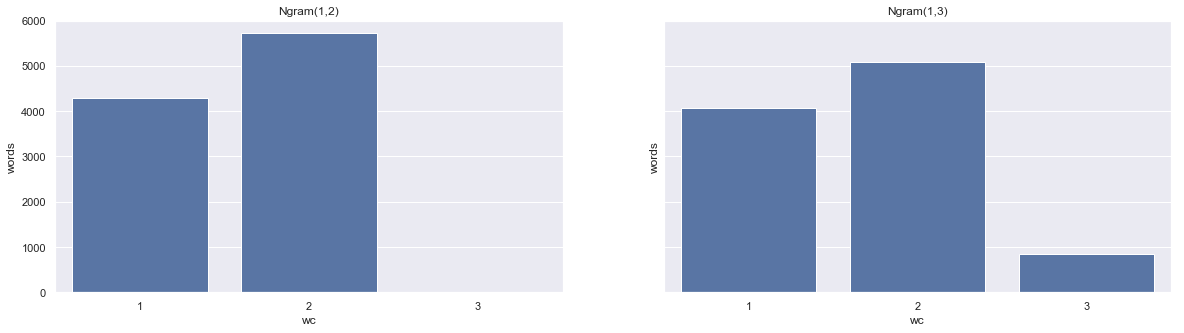

In [24]:
files = ["review_body-tfidf-df_default-ngram12-111909-10000-nolda.csv", "review_body-tfidf-df_default-ngram13-111909-10000-nolda.csv"]
f, a = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(20,5))

i = 2
for file in files:
    filename = f'dataset/feature_files/{file}'
    features = !head -1 $filename
    features = features.n.split(",")
    ngram_pd = pd.DataFrame(features, columns=["words"])
    ngram_pd["wc"] = ngram_pd["words"].apply(lambda x: len(x.split()))
    ngram_wc_pd = ngram_pd.groupby("wc").count().reset_index()
    sns.barplot(x="wc", y="words", data=ngram_wc_pd,
                    label="Total", color="b", ax=a[i-2])
    _ = a[i-2].set_title(f"Ngram(1,{i})")
    i += 1
    
# ngram_pd[ngram_pd.wc == 3]["words"].tolist()

# Time to Train Models

Let's look at where time is spent when training the models. There are 3 components that we are measuring:
    * File load time - time to load the feature file into memory
    * Fit - time it takes for sklearn.fit() function to return
    * Predict - time it takes for sklear.predict() function to return
    
    
* Overall, Random Forest is the fastest then Gradient Boosting.
* KNN spends the most amount of time in predict, while Logistic Regression and Gradient Boosting spends the most time in fit()
* Random Forest seems to return resutls immediately from both fit and predict

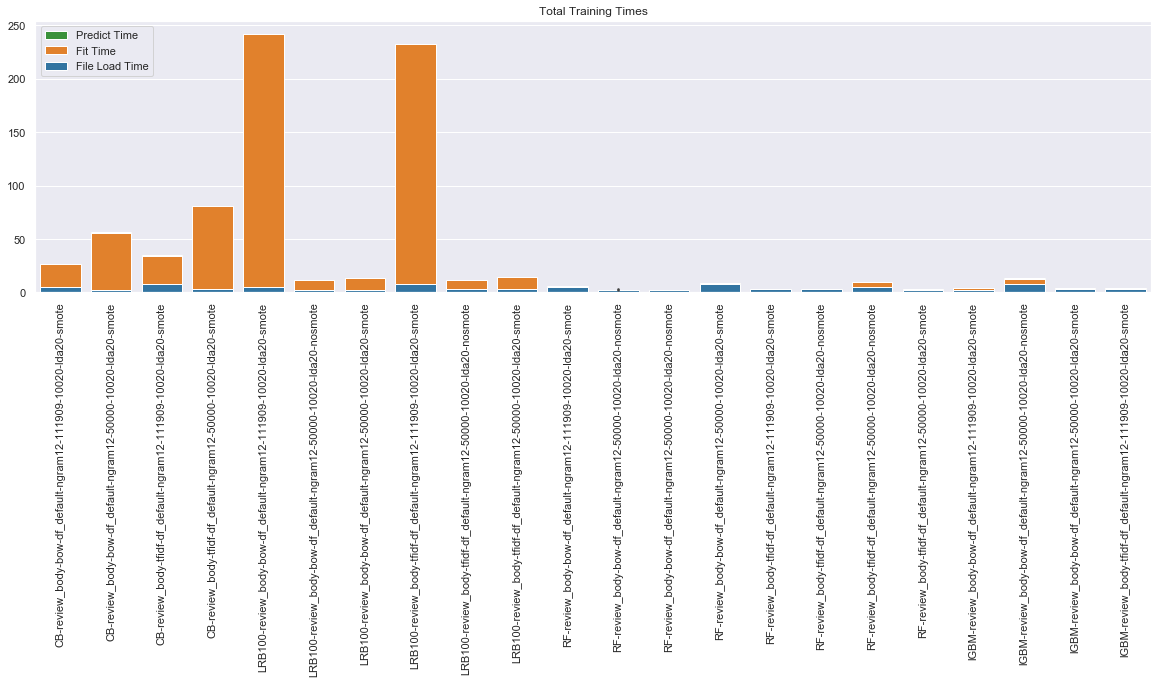

In [9]:

x = report.label.tolist()
# print(x)
predict_times = report.total_time_min.tolist()
fit_times = (report.file_load_time_min + report.train_time_min).tolist()
load_times = report.file_load_time_min.tolist()
# print(y)
f, a = plt.subplots(1, 1, figsize=(20,5))
_ = sns.barplot(x, predict_times, color="tab:green", label="Predict Time")
_ = sns.barplot(x, fit_times, color="tab:orange", label="Fit Time")
_ = sns.barplot(x, load_times, color="tab:blue", label="File Load Time")
a.legend(loc="upper left")
a.set_title("Total Training Times")
_ = a.set_xticklabels(labels=x, rotation=90)


## Average Train time

* KNN is the slowest with some outliers
* Logsitic Regression has large variations in train times

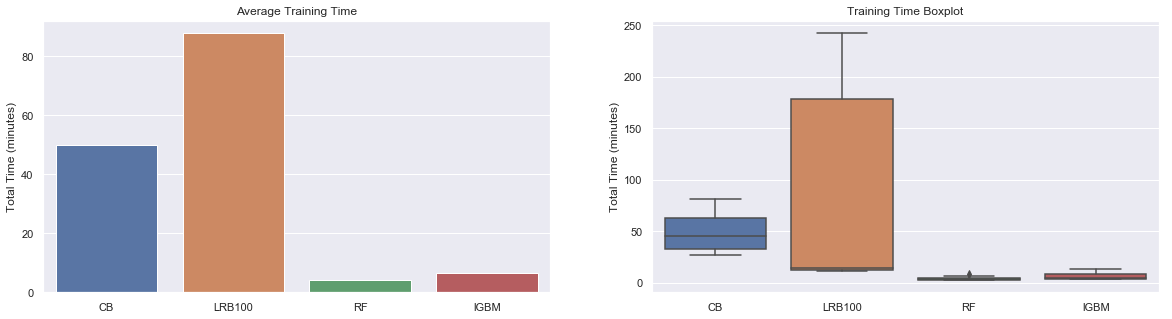

In [10]:
f, a = plt.subplots(1, 2, figsize=(20,5))

avg_train_times = []
for model in MODELS:
    avg_train_times.append(report[report["label"].str.startswith(f"{model}-")].total_time_min.mean())
    
sns.barplot(x=MODELS, y=avg_train_times, ax=a[0])
a[0].set_ylabel("Total Time (minutes)")
_ = a[0].set_title("Average Training Time")


sns.boxplot(data=report, x="model_name", y="total_time_min", ax=a[1])
a[1].set_ylabel("Total Time (minutes)")
a[1].set_xlabel("")
_ = a[1].set_title("Training Time Boxplot")


## Overall Scores

In [11]:
# set up labels for graphs to follow

MACRO_COLS = [col for col in report.columns if col.startswith("macro")]
MACRO_COLS.append("label")

CLASS_F1_COLS = [col for col in report.columns if len(re.findall(r'^(\d.+score)',col)) > 0]
CLASS_F1_COLS.append("label")

CLASS_PRECISION_COLS = [col for col in report.columns if len(re.findall(r'^(\d+_precision)',col)) > 0]
CLASS_PRECISION_COLS.append("label")
print(CLASS_PRECISION_COLS)

CLASS_RECALL_COLS = [col for col in report.columns if len(re.findall(r'^(\d+_recall)',col)) > 0]
CLASS_RECALL_COLS.append("label")
print(CLASS_RECALL_COLS)


CLASS_COLS = sorted(CLASS_F1_COLS + CLASS_PRECISION_COLS + CLASS_RECALL_COLS)
CLASS_COLS.pop()
CLASS_COLS.pop()
print(CLASS_COLS)

['1_precision', '2_precision', '3_precision', '4_precision', '5_precision', 'label']
['1_recall', '2_recall', '3_recall', '4_recall', '5_recall', 'label']
['1_f1-score', '1_precision', '1_recall', '2_f1-score', '2_precision', '2_recall', '3_f1-score', '3_precision', '3_recall', '4_f1-score', '4_precision', '4_recall', '5_f1-score', '5_precision', '5_recall', 'label']


In [12]:
macro_scores = report[MACRO_COLS].copy()
macro_scores.head()

,macro avg_f1-score,macro avg_precision,macro avg_recall,macro avg_support,label
10,0.411223,0.494177,0.418685,27978,CB-review_body-bow-df_default-ngram12-111909-1...
2,0.396278,0.493745,0.406913,12500,CB-review_body-bow-df_default-ngram12-50000-10...
14,0.415342,0.502459,0.421352,27978,CB-review_body-tfidf-df_default-ngram12-111909...
6,0.392872,0.491040,0.405458,12500,CB-review_body-tfidf-df_default-ngram12-50000-...
11,0.471528,0.466673,0.486829,27978,LRB100-review_body-bow-df_default-ngram12-1119...


## This is kind of interesting. By adding topic modeling to features, you can see that both KNN and Logistic Regression, there are spikes in total time to trail

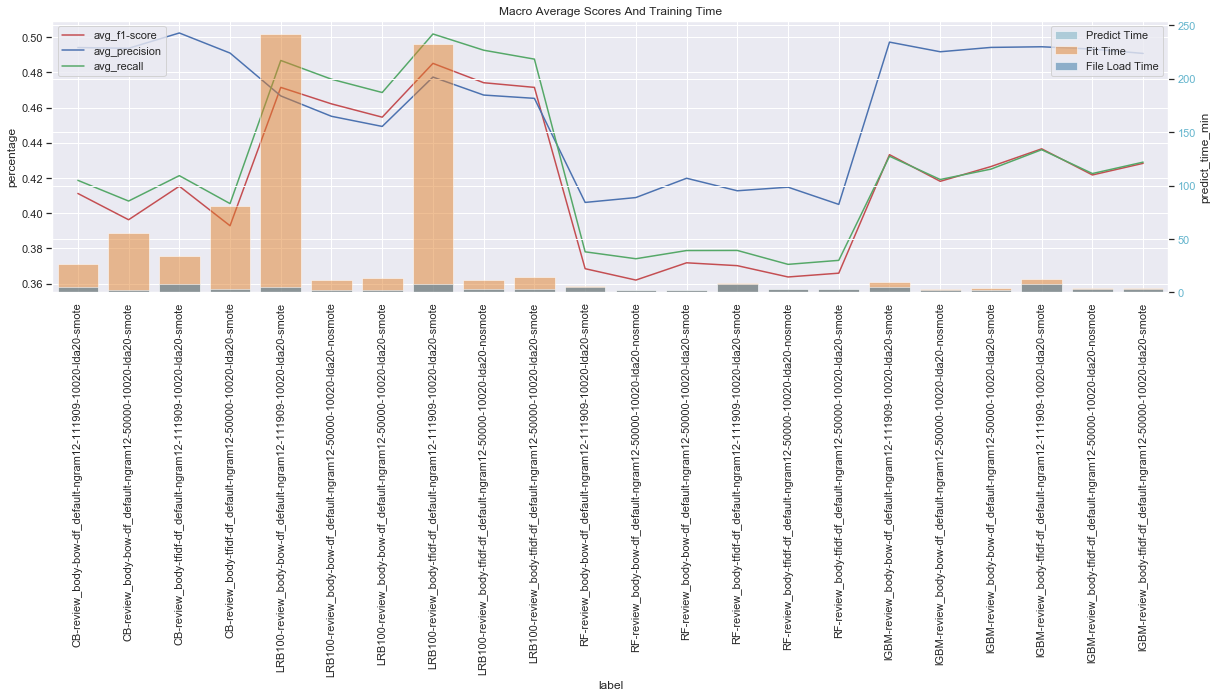

In [13]:
f, a = plt.subplots(1, 1, figsize=(20,5))

g = sns.lineplot(data=report, x="label", y="macro avg_f1-score", label="avg_f1-score", ax=a, color="r")
g = sns.lineplot(data=report, x="label", y="macro avg_precision", label="avg_precision", ax=a, color="b")
g = sns.lineplot(data=report, x="label", y="macro avg_recall", label="avg_recall", ax=a, color="g")
g.set_xticklabels(labels=report["label"], rotation=90)
g.set_ylabel("percentage")
g.set_title("Macro Average Scores And Training Time")
g.legend(loc="upper left")


ax2 = a.twinx()

x = report.label.tolist()
predict_times = report.total_time_min.tolist()
fit_times = (report.file_load_time_min + report.train_time_min).tolist()
load_times = report.file_load_time_min.tolist()

g = sns.barplot(data=report, x="label", y="predict_time_min", label="Predict Time", ax=ax2, color="c", alpha=0.5)
g = sns.barplot(x=x, y=fit_times, label="Fit Time", ax=ax2, color="tab:orange", alpha=0.5)
g = sns.barplot(x=x, y=load_times, label="File Load Time", ax=ax2, color="tab:blue", alpha=0.5)
ax2.tick_params(axis='y', labelcolor="c")
_ = ax2.legend(loc="upper right")


### Looks like for larger data sets compared to just 999 LR out-performs other models so far

In [14]:
for model in MODELS:
    model_df = macro_scores[macro_scores["label"].str.contains(model)]
    print(f'\n{model} mean: {model_df["macro avg_f1-score"].mean()}')
    print(f'{model} std: {model_df["macro avg_f1-score"].std()}')


CB mean: 0.4039287285
CB std: 0.011019329003341637

LRB100 mean: 0.4698610826666667
LRB100 std: 0.010502614479858044

RF mean: 0.36597421475
RF std: 0.0037707122586218816

lGBM mean: 0.4274356861666666
lGBM std: 0.006912323854882063


### Top 5 Models and Datasets with Highest Average F1 Score

In [15]:
macro_scores.nlargest(5, "macro avg_f1-score")

,macro avg_f1-score,macro avg_precision,macro avg_recall,macro avg_support,label
15,0.485184,0.477394,0.501890,27978,LRB100-review_body-tfidf-df_default-ngram12-11...
21,0.474177,0.467169,0.492665,12500,LRB100-review_body-tfidf-df_default-ngram12-50...
7,0.471530,0.465295,0.487594,12500,LRB100-review_body-tfidf-df_default-ngram12-50...
11,0.471528,0.466673,0.486829,27978,LRB100-review_body-bow-df_default-ngram12-1119...
18,0.462155,0.455088,0.476171,12500,LRB100-review_body-bow-df_default-ngram12-5000...


## F1 Score By Class

In [16]:
f1_class = report[CLASS_F1_COLS]
f1_class.head()

,1_f1-score,2_f1-score,3_f1-score,4_f1-score,5_f1-score,label
10,0.662589,0.082752,0.216524,0.286411,0.807838,CB-review_body-bow-df_default-ngram12-111909-1...
2,0.658699,0.063107,0.183150,0.251665,0.824767,CB-review_body-bow-df_default-ngram12-50000-10...
14,0.662586,0.091497,0.220194,0.294168,0.808266,CB-review_body-tfidf-df_default-ngram12-111909...
6,0.666667,0.054388,0.178493,0.239348,0.825463,CB-review_body-tfidf-df_default-ngram12-50000-...
11,0.657065,0.262072,0.309136,0.369557,0.759811,LRB100-review_body-bow-df_default-ngram12-1119...


In [17]:
# split into different training models
LR = report[report["label"].str.startswith("LR")]
KNN = report[report["label"].str.startswith("KNN")]
RN = report[report["label"].str.startswith("RN")]

## Let's look at F1 scores per class for each training model

### Logistic Regression seems to be doing the best so far compared to other models. class_weight seems to not have an effect on F1 score, precision, or recall

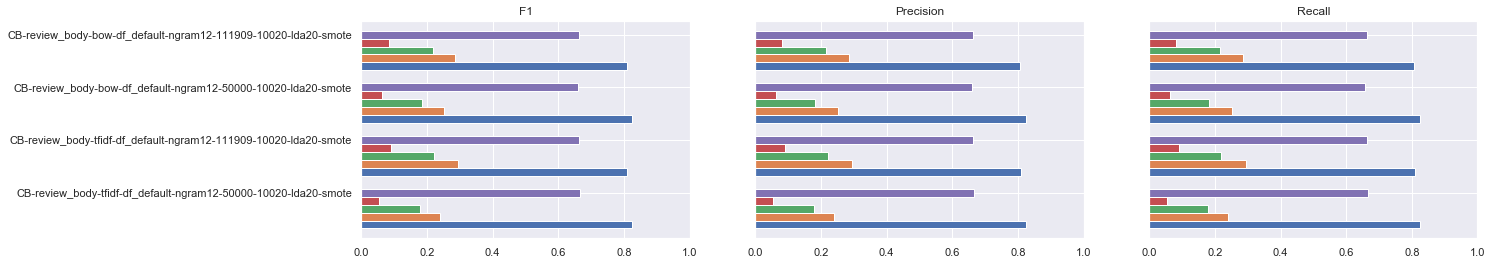

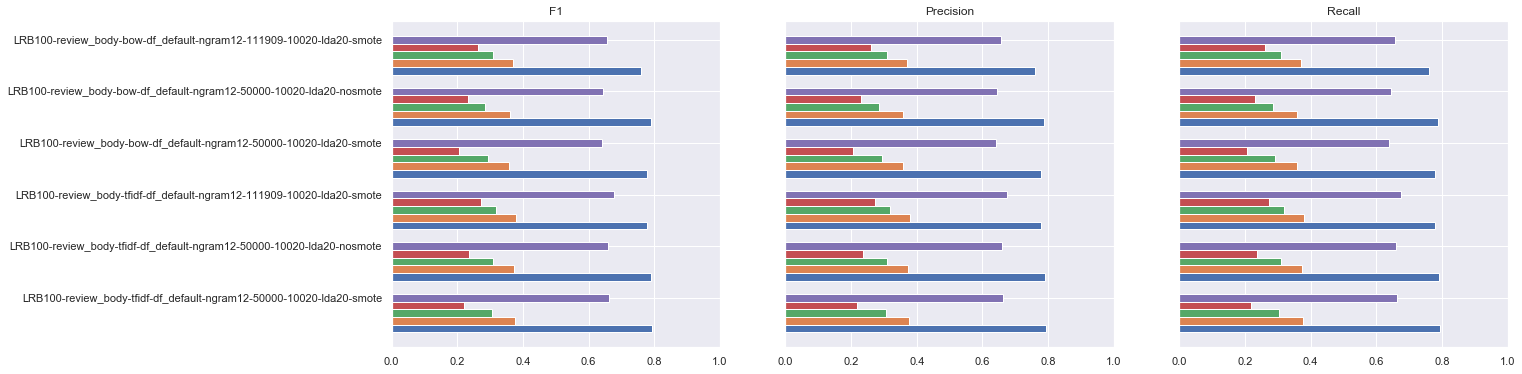

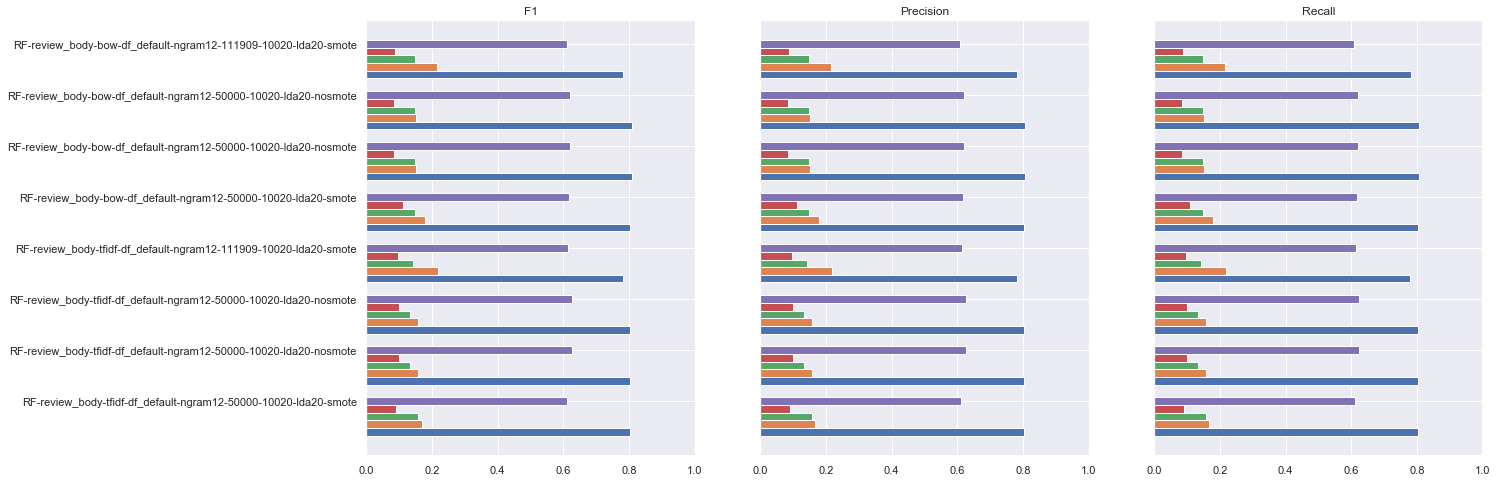

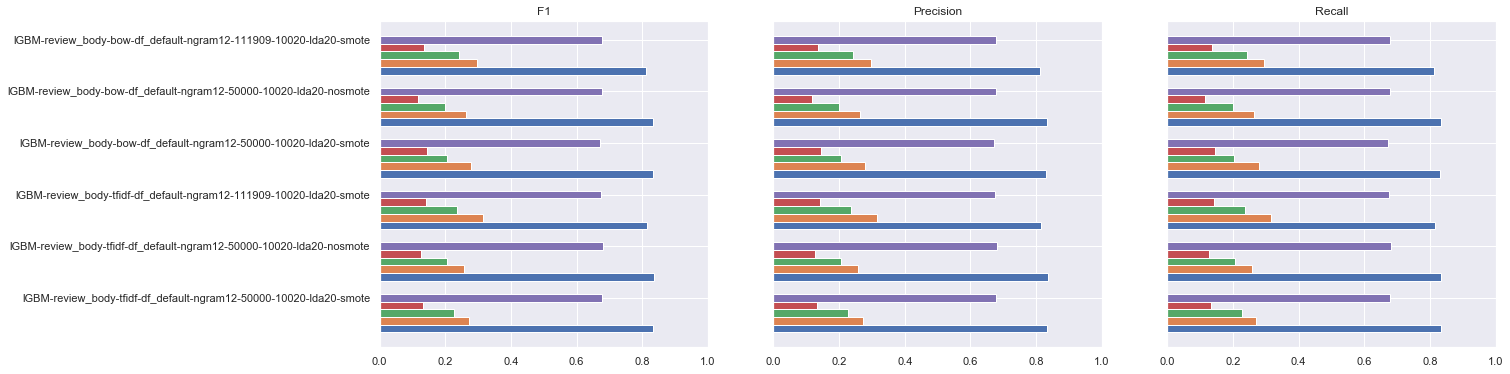

In [18]:
# programatically generate horizontal histograms


for model in MODELS:
    model_report = report[report["label"].str.startswith(f'{model}-')]

    pos = list(range(len(model_report)))
    width = 0.15
    f, a = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(20, len(model_report) * 1))
    column_dict = { "F1": CLASS_F1_COLS, "Precision": CLASS_PRECISION_COLS, "Recall": CLASS_RECALL_COLS }

    # sort the report in reverse order so we see the models top down
    report_reverse = model_report.sort_values("label", ascending=False)

    index = 0
    for title, columns in column_dict.items():
        columns_copy = CLASS_F1_COLS.copy()
        columns_copy.remove("label")
        # sort in reverse order so it goes top-down and 5 is at the bottom
        columns_copy.sort(reverse=True)

        offset = 0
        for col in columns_copy:
    #         print(f'Plotting {col}')
            a[index].barh([p + offset for p in pos], 
                    report_reverse[col], 
                    width, 
    #                 align="edge",
    #                 alpha=0.5, 
                    tick_label=report_reverse["label"].tolist(),
                    orientation="horizontal") 
            offset += width
            a[index].set_title(title)
            a[index].set_xlim(0, 1.0)
        index += 1


## Let's look at top 5 models - based on average F1 scores

* 3 out of 5 are done through Logistic Regression, although time to run the models is significantly higher than KNN
* KNN seems to be doing better with BoW
* LR seems to be doing better with TF-IDF


In [19]:
# cols = [col for col in f1_KNN.columns if col.startswith("macro f1") > 1]
largest = report.nlargest(5, "macro avg_f1-score")
largest_labels = largest["label"].tolist()
largest_avg_f1 = report[report["label"].isin(largest_labels)].sort_values("macro avg_f1-score", ascending=True)
largest_avg_f1[["macro avg_f1-score", "label", "total_time_min"]].head()

,macro avg_f1-score,label,total_time_min
18,0.462155,LRB100-review_body-bow-df_default-ngram12-5000...,11.62
11,0.471528,LRB100-review_body-bow-df_default-ngram12-1119...,242.41
7,0.471530,LRB100-review_body-tfidf-df_default-ngram12-50...,14.63
21,0.474177,LRB100-review_body-tfidf-df_default-ngram12-50...,11.85
15,0.485184,LRB100-review_body-tfidf-df_default-ngram12-11...,232.64


In [20]:
largest_avg_f1[CLASS_COLS].head(len(largest_avg_f1))

,1_f1-score,1_precision,1_recall,2_f1-score,2_precision,2_recall,3_f1-score,3_precision,3_recall,4_f1-score,4_precision,4_recall,5_f1-score,5_precision,5_recall,label
18,0.644713,0.637015,0.652599,0.231638,0.199416,0.276280,0.286089,0.257683,0.321534,0.359336,0.328756,0.396189,0.789001,0.852571,0.734252,LRB100-review_body-bow-df_default-ngram12-5000...
11,0.657065,0.660752,0.653419,0.262072,0.229002,0.306306,0.309136,0.267141,0.366797,0.369557,0.331620,0.417296,0.759811,0.844850,0.690326,LRB100-review_body-bow-df_default-ngram12-1119...
7,0.663394,0.665640,0.661162,0.219134,0.181577,0.276280,0.304956,0.267857,0.353982,0.377393,0.345865,0.415246,0.792775,0.865535,0.731299,LRB100-review_body-tfidf-df_default-ngram12-50...
21,0.660147,0.659743,0.660550,0.237069,0.197487,0.296496,0.310071,0.269622,0.364798,0.372768,0.335881,0.418756,0.790830,0.873110,0.722722,LRB100-review_body-tfidf-df_default-ngram12-50...
15,0.676306,0.665004,0.688000,0.271926,0.232742,0.326974,0.319362,0.282328,0.367578,0.380082,0.352507,0.412336,0.778245,0.854391,0.714562,LRB100-review_body-tfidf-df_default-ngram12-11...


<font color="red">for some reason the X axis as well as the line graphs are cutting off the first entry??</font>

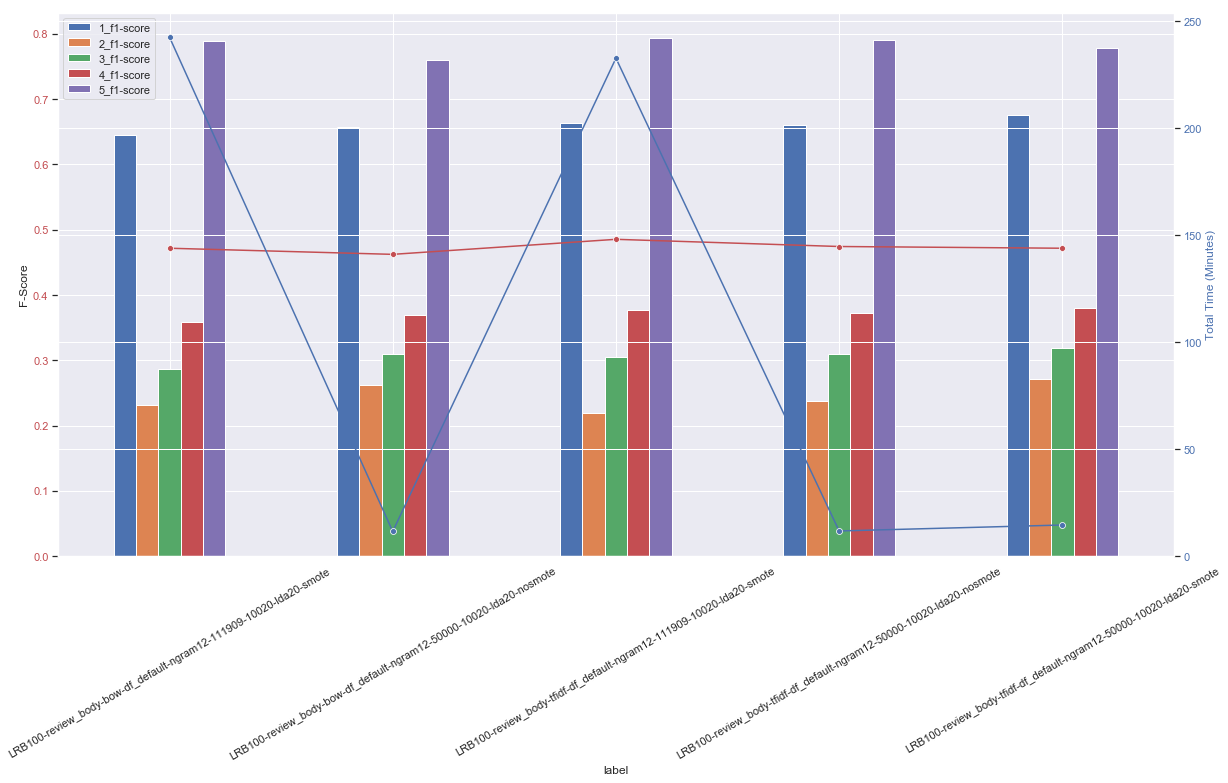

In [21]:
f, a = plt.subplots(1, 1, figsize=(20, 10))
largest_avg_f1[CLASS_F1_COLS].set_index("label").plot(kind='bar', ax=a)
sns.lineplot(data=largest_avg_f1, y="macro avg_f1-score", x="label", ax=a, color="r", marker="o")
# a[0].get_xaxis().set_visible(False)
a.set_ylabel("F-Score")
a.tick_params(axis='y', labelcolor="r")
# print(largest_labels)
a.set_xticklabels(labels=largest_labels, rotation=30)

ax2 = a.twinx()
sns.lineplot(data=largest_avg_f1, y="total_time_min", x="label", ax=ax2, color="b", marker="o", linestyle="-")
ax2.set_ylabel("Total Time (Minutes)", color="b")
ax2.tick_params(axis='y', labelcolor="b")


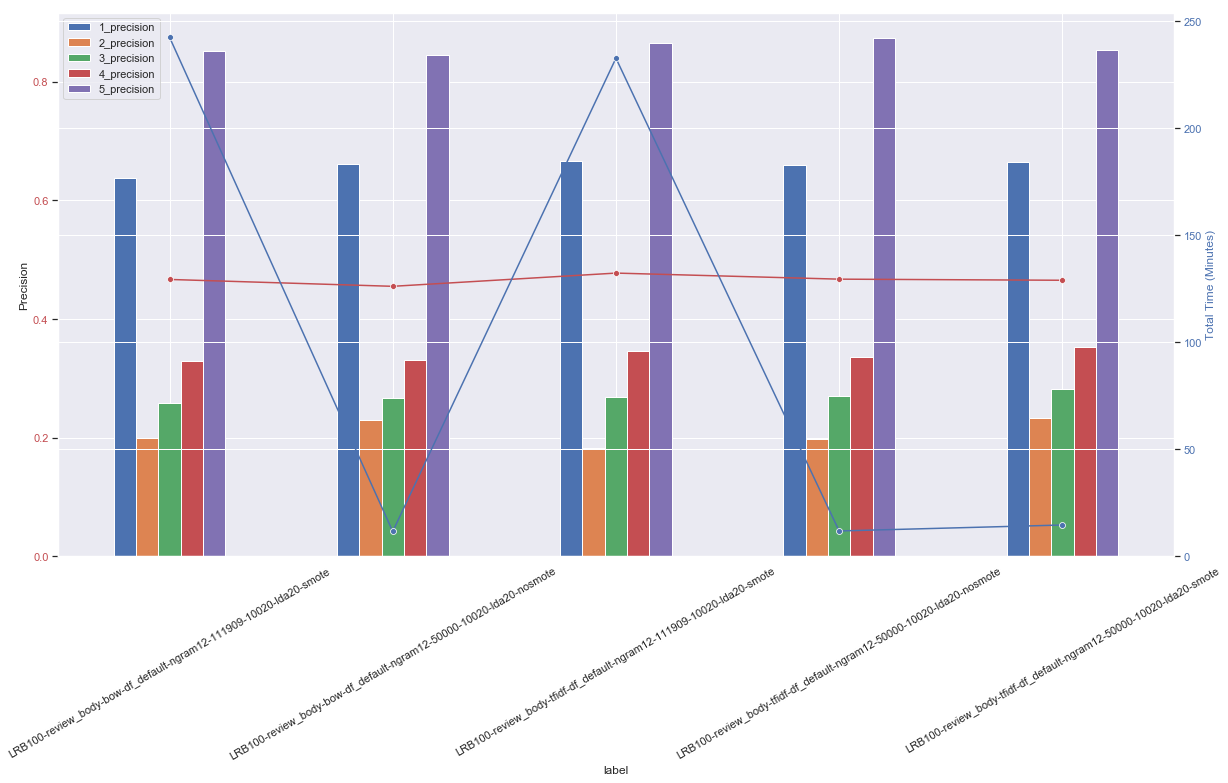

In [22]:
f, a = plt.subplots(1, 1, figsize=(20, 10))
largest_avg_f1[CLASS_PRECISION_COLS].set_index("label").plot(kind='bar', ax=a)
sns.lineplot(data=largest_avg_f1, y="macro avg_precision", x="label", ax=a, color="r", marker="o")
# a[0].get_xaxis().set_visible(False)
a.set_ylabel("Precision")
a.tick_params(axis='y', labelcolor="r")
# print(largest_labels)
a.set_xticklabels(labels=largest_labels, rotation=30)

ax2 = a.twinx()
sns.lineplot(data=largest_avg_f1, y="total_time_min", x="label", ax=ax2, color="b", marker="o", linestyle="-")
ax2.set_ylabel("Total Time (Minutes)", color="b")
ax2.tick_params(axis='y', labelcolor="b")


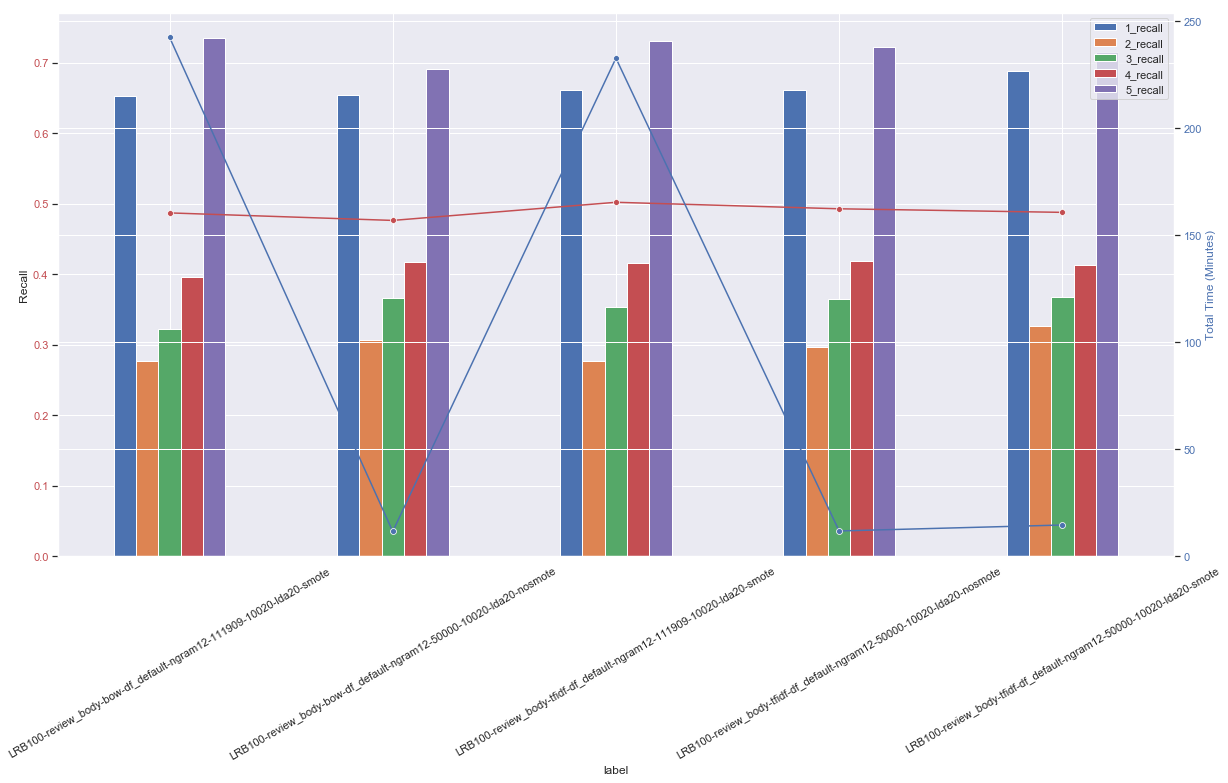

In [23]:
f, a = plt.subplots(1, 1, figsize=(20, 10))
largest_avg_f1[CLASS_RECALL_COLS].set_index("label").plot(kind='bar', ax=a)
sns.lineplot(data=largest_avg_f1, y="macro avg_recall", x="label", ax=a, color="r", marker="o")
# a[0].get_xaxis().set_visible(False)
a.set_ylabel("Recall")
a.tick_params(axis='y', labelcolor="r")
# print(largest_labels)
a.set_xticklabels(labels=largest_labels, rotation=30)

ax2 = a.twinx()
sns.lineplot(data=largest_avg_f1, y="total_time_min", x="label", ax=ax2, color="b", marker="o", linestyle="-")
ax2.set_ylabel("Total Time (Minutes)", color="b")
ax2.tick_params(axis='y', labelcolor="b")
